<h1><center>Домашняя работа #5: Нейросетевые подходы для кандидатогенерации в рекомендательных системах</center></h1>

Автор: Владимир Байкалов (Telegram: @noname_untitled)

В этой домашней работе вы реализуете и исследуете нейросетевые модели для задачи кандидатогенерации. На основе датасета логов Яндекс Музыки ["Yambda"](https://huggingface.co/datasets/yandex/yambda) вы:

1) Подготовите данные для обучения нейросетевых моделей рекомендаций
2) Реализуете SASRec — одну из самых популярных архитектур для моделирования последовательностей пользователей
3) Поэкспериментируете с различными функциями потерь

В этом домашнем задании вам предстоит самостоятельно реализовать ключевые этапы процесса обучения модели для кандидатогенерации на последовательных данных пользователя — от подготовки данных до вычисления метрик на валидации и тесте.

Во всех кодовых ячейках, отмеченных как `# TODO: your code here`, необходимо дописать свой код, реализующий соответствующий этап обработки, фильтрации, маппинга, построения датасета, компоненты модели. Это могут быть функции, фильтры, структура пайплайна, реализация классов и методы.

В конце каждого подзадания вас ждут поверхностные тесты (sanity checks) — это простые проверки, которые служат базовой валидацией ваших решений, но НЕ являются исчерпывающими. Их прохождение не гарантирует полной корректности реализации, однако помогает быстро заметить типовые ошибки и опечатки на ранних этапах.

Система оценивания:
- За задания 1 и 2 (работа с данными, подготовка пайплайна, обработка) можно получить баллы за корректную реализацию — то есть ваш код проходит все sanity-check тесты.

- Баллы за задания 3–6 (реализация метрик и различных лоссов) начисляются только в том случае, если в конце ноутбука ваша модель успешно проходит итоговые тесты на качество, а метрики на валидации/тесте достигают пороговых значений.

Ваша задача: пройти весь путь — от сырых данных и до обученных моделей и финальных метрик их качества.

# 🔧 Настройка рабочего окружения

## 📦 Установка необходимых зависимостей

In [ ]:
# Ниже в ячейке стоят именно те версии, которые были у меня. Можете менять их на свой страх и риск :)
!pip install datasets==4.4.1 -i https://pypi.org/simple
!pip install polars==1.33.1 -i https://pypi.org/simple

## 📚 Импорт необходимых библиотек

In [ ]:
from collections import defaultdict, Counter
from typing import Any, Dict, List, Optional, Tuple

from datasets import load_dataset

import numpy as np

import polars as pl

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## ⚙️ Определение гиперпараметров

In [ ]:
# Data
HOUR_SECONDS = 60 * 60
DAY_SECONDS = 24 * HOUR_SECONDS

VAL_SIZE = 1 * DAY_SECONDS
TEST_SIZE = 1 * DAY_SECONDS

LAST_TIMESTAMP = 26000000
TEST_TIMESTAMP = LAST_TIMESTAMP - TEST_SIZE

# Model
HASH_DIM = 64
LEARNING_RATE = 1e-3
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 1024
NUM_EPOCHS = 15

EMBEDDING_DIM = 64
NUM_HEADS = 2
MAX_SEQ_LEN = 200
MIN_SEQ_LEN = 2
DROPOUT_RATE = 0.0
NUM_TRANSFORMER_LAYERS = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 🗂️ Подготовка данных

## 🎵 Датасет: Yandex Music Behavior (Yambda)

Датасет поведения пользователей музыкального сервиса Яндекса, содержащий реальные истории прослушиваний с информацией о взаимодействиях пользователей с треками. Каждая запись представляет последовательность событий для пользователя, включая временные метки, информацию о треках и метрики заинтересованности.

Структура данных:
- user_id: идентификатор пользователя
- item_id: последовательность идентификаторов треков, услышанных пользователем
- timestamp: время события в секундах с эпохи
- played_ratio_pct: процент прослушанного трека (0–100)
- is_organic: флаг органичности (1 = явный выбор пользователя, 0 = рекомендации)
- track_length_seconds: длительность трека в секундах

Датасет подходит для тестирования моделей последовательной рекомендации благодаря его масштабу, хронологической структуре и информации о реальном поведении пользователей.

Yambda предоставляется в нескольких форматах и размерностях:

Форматы:
- `flat`: сырые логи событий без группировки (каждое событие — отдельная строка)
- `sequence`: предварительно сгруппированные последовательности по пользователям (готовые истории взаимодействий)

Размеры:
- `50m`: 50 млн событий (компактная версия для локального тестирования)
- `500m`: 500 млн событий (среднего масштаба)
- `5b`: 5 млрд событий (полный датасет)

В этой работе мы используем `sequence` формат в размере `50m` для скорости и доступности по ресурсам. Однако стоит отметить, что на больших вариациях (`500m` и `5b`) преимущества нейросетевых подходов над классическими методами выражены значительно ярче. Желающие могут изучить это в [статье от Яндекса](https://arxiv.org/abs/2505.22238).


#### Функция для последовательного разделения данных на train/val/test

In [ ]:
# Source: https://huggingface.co/datasets/yandex/yambda

def sequential_split_train_val_test(
    df: pl.LazyFrame,
    test_timestamp: int,
    val_size: int = 0,
    gap_size: int = 0,
    drop_non_train_items: bool = False,
    engine: str = 'streaming',
) -> tuple[pl.LazyFrame, pl.LazyFrame | None, pl.LazyFrame]:
    """
    Splits the dataset into training, validation, and test segments based on the provided timestamps.

    The segments are defined as follows:
    - Training set: [0, test_timestamp - gap_size - val_size - gap_size) if val_size != 0,
                    otherwise [0, test_timestamp - gap_size)
    - Validation set: [test_timestamp - val_size - gap_size, test_timestamp - gap_size), if val_size != 0
    - Test set: [test_timestamp, +inf)

    It retains only those users and items in the validation and test sets that exist in the training set.

    Parameters:
    ----------
    df : LazyFrame
        The dataset in Polars' LazyFrame format.
    test_timestamp : int | None
        The timestamp marking the start of the test set;
    val_size : int | None
        The size of validation. If 0, no validation set is created.
    gap_size : int
        The duration of gap between training and validation/test sets.
    drop_non_train_items : bool
        Whether to drop items that are not in the training set.

    Returns:
    -------
    tuple[LazyFrame, LazyFrame | None, LazyFrame]
        A tuple containing LazyFrames for the training, validation (if applicable), and test sets.
    """

    def drop(df: pl.LazyFrame, unique_train_item_ids) -> pl.LazyFrame:
        if not drop_non_train_items:
            return df

        return df.select(
            'uid',
            pl.all()
            .exclude('uid')
            .list.gather(
                pl.col('item_id').list.eval(
                    pl.arg_where(pl.element().is_in(unique_train_item_ids.get_column('item_id').implode()))
                )
            ),
        ).filter(pl.col('item_id').list.len() > 0)

    train_timestamp = test_timestamp - gap_size - val_size - (gap_size if val_size != 0 else 0)

    assert gap_size >= 0
    assert val_size >= 0
    assert train_timestamp > 0

    df_lazy = df.lazy()

    train = df_lazy.select(
        'uid',
        pl.all()
        .exclude('uid')
        .list.gather(pl.col('timestamp').list.eval(pl.arg_where(pl.element() < train_timestamp))),
    ).filter(pl.col('item_id').list.len() > 0)

    unique_train_uids = train.select('uid').unique().collect(engine=engine)
    unique_train_item_ids = train.explode('item_id').select('item_id').unique().collect(engine=engine)

    validation = None
    if val_size != 0:
        validation = (
            df_lazy.select(
                'uid',
                pl.all()
                .exclude('uid')
                .list.gather(
                    pl.col('timestamp').list.eval(
                        pl.arg_where(
                            (pl.element() >= test_timestamp - val_size - gap_size)
                            & (pl.element() < test_timestamp - gap_size)
                        )
                    )
                ),
            )
            .with_columns(
                pl.col('uid').is_in(unique_train_uids.get_column('uid').implode()).alias('uid_in_train')
            )  # to prevent filter reordering
            .filter('uid_in_train')
            .drop('uid_in_train')
        )

        validation = drop(validation, unique_train_item_ids).filter(pl.col('item_id').list.len() > 0)

    test = (
        df_lazy.select(
            'uid',
            pl.all()
            .exclude('uid')
            .list.gather(pl.col('timestamp').list.eval(pl.arg_where(pl.element() >= test_timestamp))),
        )
        #
        .with_columns(
            pl.col('uid').is_in(unique_train_uids.get_column('uid').implode()).alias('uid_in_train')
        )  # to prevent filter reordering
        .filter('uid_in_train')
        .drop('uid_in_train')
    )

    test = drop(test, unique_train_item_ids).filter(pl.col('item_id').list.len() > 0)

    return train, validation, test

## 🔍 Про предобработку датасетов для обучения моделей

В современных исследованиях рекомендательных систем используется стандартизированный конвейер предобработки данных для воспроизводимости результатов. Во многих статьях по рекомендательным системам используется устоявшаяся схема предобработки датасетов:

1. **Фильтрация редких сущностей**: Удаляются пользователи и айтемы (товары/фильмы/etc), у которых количество взаимодействий меньше определенного порога. Это снижает разреженность матрицы взаимодействий и минимизирует шум. Для датасетов Amazon, которые довольно популярны в академии, есть специальная нотация '5-core'. Однако, для Yambda мы пропустим этот шаг, ак как похожая фильтрация была сделана на этапе создания датасета.

2. **Стратегии разделения данных**: Довольно часто в работах используется leave-one-out (LOO) подход (оставлем последний айтем для теста, предпоследний для валидации, остальное train), но мы сделаем time-split, так как LOO пораждает утечку информации (`data leakage`) — модель не должна видеть будущие события при обучении, и плохо коррелирует с production сценариями.

3. **Процесс обучения и оценки**: Будем использовать обучающую выборку для поиска лучших весов модели, валидационную -- для подброра гиперпараметров и early-stopping'а, на тестовой будем получать финальные метрики.

## 🛠️ Task 1. Подготовка данных (2 балла)

1️⃣ Скачайте из открытых источников реальный датасет пользовательских взаимодействий с треками.

In [ ]:
format = 'sequential'
size = '50m'
events = 'listens'

# Загружаем датасет с Hugging Face Hub
listens_data = load_dataset('yandex/yambda', data_dir=f'{format}/{size}', data_files=f'{events}.parquet')

# Конвертируем в Polars DataFrame для дальнейней работы
yambda_df = pl.from_arrow(listens_data['train'].data.table)

In [ ]:
def test_yambda_data_loading():    
    assert isinstance(yambda_df, pl.DataFrame), 'yambda_df должен быть Polars DataFrame'
    assert yambda_df.shape == (9238, 6), f'Неправильный размер: {yambda_df.shape}'
    
    expected_cols = {'uid', 'timestamp', 'item_id', 'is_organic', 'played_ratio_pct', 'track_length_seconds'}
    assert set(yambda_df.columns) == expected_cols, f'Неправильные колонки: {yambda_df.columns}'

    assert yambda_df['item_id'].dtype == pl.List(pl.UInt32), 'item_id должен быть List[UInt32]'
    assert yambda_df['timestamp'].dtype == pl.List(pl.UInt32), 'timestamp должен быть List[UInt32]'

    assert yambda_df['item_id'].list.len().min() > 0, 'Есть пустые истории'
    
    print('✅ test_yambda_data_loading: OK')

test_yambda_data_loading()

2️⃣ Отфильтруйте данные, оставив только события, которые были рекомендованы пользователю (органичные взаимодействия) и были прослушаны более чем наполовину. Удалите истории,где не осталось событий после фильтрации. Это позволит модели учиться на более качественных и репрезентативных данных.

In [ ]:
yambda_df = ...  # TODO: your code here

In [ ]:
def test_yambda_filtering():
    assert yambda_df.shape[0] == 8592, \
        f'Неправильное количество пользователей: {yambda_df.shape[0]}'
    
    expected_columns = {'uid', 'timestamp', 'item_id'}
    actual_columns = set(yambda_df.columns)
    assert actual_columns == expected_columns, \
        f'Неправильные колонки. Ожидалось: {expected_columns}, получено: {actual_columns}'
    
    assert yambda_df['timestamp'].dtype == pl.List(pl.UInt32), \
        f"timestamp должен быть List[UInt32], получено: {yambda_df['timestamp'].dtype}"
    assert yambda_df['item_id'].dtype == pl.List(pl.UInt32), \
        f"item_id должен быть List[UInt32], получено: {yambda_df['item_id'].dtype}"
    
    seq_lengths = yambda_df['item_id'].list.len()
    assert seq_lengths.min() >= 1, \
        f'Минимальная длина последовательности должна быть >= 1, получено: {seq_lengths.min()}'
    assert seq_lengths.sum() == 15317548, \
        f'Общее количество событий неверно. Ожидалось: 15317548, получено: {seq_lengths.sum()}'
    
    unique_items = yambda_df.select('item_id').explode('item_id').unique().shape[0]
    assert unique_items == 410070, \
        f'Количество уникальных айтемов неверно. Ожидалось: 410070, получено: {unique_items}'
    
    print('✅ test_yambda_filtering: OK')

test_yambda_filtering()

3️⃣ Получите все уникальные ID треков из датасета и создайте маппинг: старый_id - новый_id, где новый_id находится в диапазоне от 0 до N - 1.

Модели глубокого обучения требуют, чтобы категориальные признаки (в нашем случае ID треков) были представлены целыми числами в диапазоне от 0 до N-1, где N — количество уникальных треков. Датасет Yambda содержит оригинальные ID треков, которые могут быть разреженными (например, [100, 5000, 7, 12000, ...]) — это неэффективно для embedding-таблиц.

In [ ]:
unique_items = ... # TODO: your code here

item_mapping = ...  # TODO: your code here

yambda_df = yambda_df.with_columns([
    pl.col('item_id')
        .map_elements(
            lambda items: [item_mapping[item] for item in items],
            return_dtype=pl.List(pl.UInt32)
        )
        .alias('item_id')
])

In [ ]:
def test_item_mapping():    
    assert unique_items.shape == (410070, 2), f'Неправильный размер unique_items: {unique_items.shape}'
    assert set(unique_items.columns) == {'new_item_id', 'item_id'}, 'Неправильные колонки unique_items'
    
    assert len(item_mapping) == 410070, f'Неправильный размер item_mapping: {len(item_mapping)}'
    assert item_mapping[50] == 0 and item_mapping[175] == 1 and item_mapping[195] == 2, \
        'Неверные первые маппинги'
    
    new_ids = unique_items['new_item_id']
    assert new_ids.min() == 0 and new_ids.max() == 410069, 'new_item_id должны быть в [0, 410069]'
    
    all_ids = yambda_df.select('item_id').explode('item_id')['item_id']
    assert all_ids.min() == 0 and all_ids.max() == 410069, 'item_id в yambda_df не обновлены'
    assert all_ids.n_unique() == 410070, 'Количество уникальных item_id изменилось'
    
    print('✅ test_item_mapping: OK')

test_item_mapping()


4️⃣ Разделите историю прослушиваний пользователей на три непересекающихся временных периода. 

- Валидационная и тестовая выборки должны содержать по одному дню событий каждая, а обучающая — все остальные данные до них. 
- Зазоры между периодами должны отсутствовать (данные должны идти "вплотную").

In [ ]:
train_events_df, valid_events_df, eval_events_df = ...  # TODO: your code here

In [ ]:
def test_yambda_train_val_test_split():
    assert train_events_df.shape[0] == (8580), \
        f'Неправильное количество пользователей: {train_events_df.shape[0]}'
    assert valid_events_df.shape[0] == (2823), \
        f'Неправильное количество пользователей: {valid_events_df.shape[0]}'
    assert eval_events_df.shape[0] == (2849), \
        f'Неправильное количество пользователей: {eval_events_df.shape[0]}'

    assert isinstance(train_events_df, pl.DataFrame), 'Неправильный тип'
    assert isinstance(valid_events_df, pl.DataFrame), 'Неправильный тип'
    assert isinstance(eval_events_df, pl.DataFrame), 'Неправильный тип'

    assert train_events_df.select(pl.col('item_id').list.len()).sum().item() == 15155113, \
        'Неправильное количество событий в обучающей выборке'
    assert valid_events_df.select(pl.col('item_id').list.len()).sum().item() == 78403, \
        'Неправильное количество событий в валидационной выборке'
    assert eval_events_df.select(pl.col('item_id').list.len()).sum().item() == 83711, \
        'Неправильное количество событий в тестовой выборке'
    
    print('✅ test_yambda_train_val_test_split: OK')

test_yambda_train_val_test_split()

5️⃣ Соедините три разделённых выборки (`train`/`val`/`test`) в одну таблицу по пользователям (`uid`). Результат должен содержать для каждого пользователя его историю на всех трёх этапах: обучение, валидацию и тест.

In [ ]:
joined_events_df = ...  # TODO: your code here

In [ ]:
def test_yambda_all_join():
    assert joined_events_df.shape[0] == (8580), \
        f'Неправильное количество пользователей: {joined_events_df.shape[0]}'
    
    assert min(list(map(len, joined_events_df['item_id'].to_list()))) == 1
    assert max(list(map(len, joined_events_df['item_id'].to_list()))) == 25643
    
    print('✅ test_yambda_all_join: OK')

test_yambda_all_join()


6️⃣ Постройте обучающую, валидационную и тестовую выборки.

Для обучающей выборки оставьте только тех пользователей, чьи истории содержат достаточно событий (не менее MIN_SEQ_LEN треков).

Для валидационной выборки создайте инкрементальные последовательности: для каждого пользователя из валидационного периода создайте несколько семплов, где история состоит из всех train событий плюс постепенно добавляемые valid события (1-е, 1-2-е, 1-2-3-е и т.д.). Это позволяет оценить, насколько хорошо модель предсказывает следующий трек при расширении истории.

Для тестовой выборки проделайте то же самое что и для валидации, но начинайте с полной train истории + все valid события, затем добавляйте test события инкрементально.

In [ ]:
train_data = ... # TODO: your code here

In [ ]:
def test_train_data():
    assert train_data.shape == (8482, 3), f'Неправильный размер: {train_data.shape}'
    assert train_data.columns == ['uid', 'timestamp', 'item_id'], 'Неправильные колонки'

    assert train_data['item_id'].list.len().min() >= MIN_SEQ_LEN, \
        'Есть последовательности короче MIN_SEQ_LEN'
    
    assert train_data['item_id'].list.len().sum() == 15155015, 'Неверное количество событий'
    
    assert train_data['uid'].head(5).to_list() == [100, 300, 500, 600, 700], 'Неверные первые uid'
    
    print('✅ test_train_data: OK')

test_train_data()


In [ ]:
valid_data = ...  # TODO: your code here

In [ ]:
def test_valid_data():    
    assert valid_data.shape == (78403, 3), f'Неправильный размер: {valid_data.shape}'
    assert valid_data.columns == ['uid', 'timestamp', 'item_id'], 'Неправильные колонки'
    
    assert valid_data['item_id'].list.len().min() >= MIN_SEQ_LEN, \
        'Есть последовательности короче MIN_SEQ_LEN'
    
    assert valid_data['item_id'].list.len().sum() == 414802466, 'Неверное количество событий'
    
    assert valid_data['uid'].head(5).to_list() == [100, 100, 100, 100, 100], 'Неверные первые uid'
    
    first_user_lens = valid_data.filter(pl.col('uid') == 100)['item_id'].list.len().to_list()[:5]
    assert first_user_lens == sorted(first_user_lens), 'Длины должны расти инкрементально'
    
    print('✅ test_valid_data: OK')

test_valid_data()


In [ ]:
eval_data = ...  # TODO: your code here

In [ ]:
def test_eval_data():
    assert eval_data.shape == (83711, 3), f'Неправильный размер: {eval_data.shape}'
    assert eval_data.columns == ['uid', 'timestamp', 'item_id'], 'Неправильные колонки'

    assert eval_data['item_id'].list.len().min() >= MIN_SEQ_LEN, \
        'Есть последовательности короче MIN_SEQ_LEN'
    
    assert eval_data['item_id'].list.len().sum() == 432679119, 'Неверное количество событий'
    
    assert eval_data['uid'].head(5).to_list() == [100, 100, 100, 100, 100], 'Неверные первые uid'
    
    first_user_lens = eval_data.filter(pl.col('uid') == 100)['item_id'].list.len().head(5).to_list()
    assert first_user_lens == sorted(first_user_lens), 'Длины должны расти инкрементально'
    
    assert eval_data['item_id'].list.len().sum() > valid_data['item_id'].list.len().sum(), \
        'eval_data должен быть больше valid_data'
    
    print('✅ test_eval_data: OK')

test_eval_data()


Семплы, которые мы будем передавать в модель будут иметь следующую структуру:

- `history`
    - `item_id` (исторические взаимодействия пользователя)
    - `lengths` (количество взаимодействий в истории пользователя)
    - `positions` (номера позиций в обратном порядке)
- `labels`
    - `item_id` (позитивы, котороый модель должна предсказать, a.k.a следующее взаимодействие)


7️⃣ Реализуйте класс `YambdaDataset`, который преобразует подготовленные истории пользователей в формат, удобный для обучения нейросетевых моделей.

Требования:

- В методе `__len__`: верните количество семплов в датасете

- В методе `__getitem__`: по индексу получите семпл и верните словарь с двумя ключами:

    - `history` -- словарь, представляющий контекст (то, что видит модель):
        - `item_id` -- последовательность треков (без последнего события из исходной истории)
        - `lengths` -- длина этой последовательности
        - `positions` -- порядковые номера событий (от 0 до длины последовательности)

    - `labels` -- словарь, представляющий таргеты (то, что нужно предсказать):
        - `item_id` -- последовательность целевых треков (без первого события из исходной истории)

    - Ограничьте обе последовательности `item_id` до `max_seq_len`, оставляя последние события — они отражают свежий интерес пользователя

Сдвиг между `history/item_id` и `labels/item_id` создаёт пары "контекст-таргет", необходимые для авторегрессионного обучения. Каждое событие в истории получает соответствующий таргет (следующий айтем), что позволяет модели учиться предсказывать следующий трек на основе предыдущих.

In [ ]:
class YambdaDataset(Dataset):
    """
    PyTorch Dataset for sequential user interaction histories.

    Transforms user listening sequences into format suitable for training autoregressive 
    recommendation models. Creates (history, target) pairs where the target is shifted 
    by one event forward relative to the history.

    For each user:
    - history: events [0:-1] (all except last)
    - labels: events [1:] (all except first)

    This enables the model to learn predicting the next track based on previous events 
    in the user's history.

    Parameters
    ----------
    dataframe : pl.DataFrame
        DataFrame with columns 'uid', 'timestamp', 'item_id', where item_id 
        contains sequences (lists) of user interaction events.
    max_seq_len : int
        Maximum sequence length. Histories are truncated keeping the last 
        (most recent) events.

    Returns
    -------
    Dict[str, Dict[str, Any]]
        Dictionary with keys 'history' and 'labels':
        - history['item_id']: list of track IDs
        - history['lengths']: sequence length
        - history['positions']: ordinal numbers [0, 1, ..., len-1]
        - labels['item_id']: list of target IDs (targets)

    Examples
    --------
    >>> dataset = YambdaDataset(train_data, max_seq_len=200)
    >>> sample = dataset[0]
    >>> sample['history']['item_id']  # [track_id_1, track_id_2, track_id_3, ...]
    >>> sample['labels']['item_id']   # [track_id_2, track_id_3, track_id_4, ...]
    """
    def __init__(
            self, 
            dataframe: pl.DataFrame,
            max_seq_len: int,
        ) -> None:
        super().__init__()
        # TODO: your code here
        pass

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.

        Returns
        -------
        int
            Number of rows in the DataFrame.
        """
        # TODO: your code here
        pass

    def __getitem__(self, index: int) -> Dict[str, List[int]]:
        """
        Retrieves a sample by index and transforms it into format for training.

        Parameters
        ----------
        index : int
            Index of the sample in the dataset.

        Returns
        -------
        Dict[str, Dict[str, Any]]
            Dictionary with 'history' (context) and 'labels' (targets).
            History is truncated to max_seq_len, keeping last events.
        """
        # TODO: your code here
        pass

In [ ]:
def test_yambda_dataset():
    max_seq_len = 20
    dataset = YambdaDataset(train_data, max_seq_len=max_seq_len)

    assert len(dataset) == train_data.shape[0], \
        f'Некорректная длина датасета. Ожидалось: {train_data.shape[0]}, получено: {len(dataset)}'
    
    sample = dataset[0]
    assert isinstance(sample, dict), 'Семпл должен быть словарём'
    assert 'history' in sample and 'labels' in sample, "Ключи 'history' и 'labels' обязательны"
    
    hist = sample['history']
    assert 'item_id' in hist and 'lengths' in hist and 'positions' in hist, "Недостающие ключи в 'history'"
    assert isinstance(hist['item_id'], list), "'history/item_id' должен быть списком"
    assert isinstance(hist['positions'], list), "'history/positions' должен быть списком"
    assert isinstance(hist['lengths'], int), "'history/lengths' должен быть int"
    assert len(hist['positions']) == hist['lengths'] == len(hist['item_id']), 'Длины позиций и истории не совпадают'
    assert hist['lengths'] <= max_seq_len, 'Длина истории превышает max_seq_len'
    
    labels = sample['labels']
    assert 'item_id' in labels, "'labels' должен содержать 'item_id'"
    assert isinstance(labels['item_id'], list), "'labels/item_id' должен быть списком"
    assert len(labels['item_id']) == hist['lengths'], 'Размеры history и labels не совпадают'
    
    row_item_id = train_data['item_id'][0]
    if len(row_item_id) > max_seq_len:
        row_item_id = row_item_id[-(max_seq_len+1):]
    expected_history = row_item_id[:-1]
    expected_labels = row_item_id[1:]
    assert tuple(hist['item_id']) == tuple(expected_history), f"Неверная история! {hist['item_id']} vs {expected_history}"
    assert tuple(labels['item_id']) == tuple(expected_labels), f"Неверные таргеты! {labels['item_id']} vs {expected_labels}"
    
    print('✅ test_yambda_dataset: OK')

test_yambda_dataset()

8️⃣ Реализуйте функцию `collate_fn`, которая будет использоваться в для преобразования батча семплов в формат, удобный для передачи в модель.

Функция должна:
- Принимать список словарей (батч семплов из `YambdaDataset`)
- Преобразовывать все списки элементов в единый PyTorch тензор
- Преобразовывать все скалярные значения в тензоры
- Возвращать единый словарь, где все значения имеют тип `torch.Tensor`

In [ ]:
def collate_fn(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Collates a batch of samples into a single batched tensor representation.

    Parameters
    ----------
    batch : List[Dict[str, Any]]
        A list of samples returned by __getitem__, where each sample is a dictionary.

    Returns
    -------
    Dict[str, Any]
        A dictionary with the same structure as input samples, but where all leaf values 
        are PyTorch tensors of dtype torch.long. Nested dictionaries are preserved, 
        with tensors at the leaf level.

    Examples
    --------
    >>> batch = [
    ...     {
    ...         'history': {'item_id': [1, 2, 3], 'lengths': 3, 'positions': [0, 1, 2]},
    ...         'labels': {'item_id': [2, 3, 4]}
    ...     },
    ...     {
    ...         'history': {'item_id': [5, 6], 'lengths': 2, 'positions': [0, 1]},
    ...         'labels': {'item_id': [6, 7]}
    ...     }
    ... ]
    >>> result = collate_fn(batch)
    >>> result['history']['item_id']
    tensor([[1, 2, 3, 5, 6]], dtype=torch.long)
    >>> result['history']['lengths']
    tensor([3, 2], dtype=torch.long)
    """
    # TODO: your code here
    pass

In [ ]:
def test_collate_fn():
    """Проверяет корректность батчирования функцией collate_fn."""
    
    batch = [
        {'history': {'item_id': [1, 2, 3], 'lengths': 3, 'positions': [0, 1, 2]}, 'labels': {'item_id': [2, 3, 4]}},
        {'history': {'item_id': [5, 6], 'lengths': 2, 'positions': [0, 1]}, 'labels': {'item_id': [6, 7]}},
    ]

    result = collate_fn(batch)
    
    assert isinstance(result['history']['item_id'], torch.Tensor), 'item_id должен быть тензором'
    assert result['history']['item_id'].dtype == torch.long, 'dtype должен быть long'
    
    assert result['history']['item_id'].tolist() == [1, 2, 3, 5, 6], 'Неверная конкатенация item_id'
    assert result['history']['positions'].tolist() == [0, 1, 2, 0, 1], 'Неверная конкатенация positions'
    
    assert result['history']['lengths'].tolist() == [3, 2], 'Неверные lengths'
    
    assert result['labels']['item_id'].tolist() == [2, 3, 4, 6, 7], 'Неверные labels'
    
    assert result['history']['lengths'].sum().item() == len(result['history']['item_id']), \
        'Сумма lengths != длина item_id'
    
    print('✅ test_collate_fn: OK')

test_collate_fn()


# Про SASRec модель

## 📖 Немного теории про SASRec

<img src="./sasrec.png"/> 

### 🧐 **Что такое SASRec?**
SASRec (Self-Attentive Sequential Recommendation) - это нейросетевая модель для последовательных рекомендаций, основанная на архитектуре трансформера и механизме самовнимания (self-attention). Модель была предложена в 2018 году (Wang-Cheng Kang, Julian McAuley). Её цель - эффективно учитывать как краткосрочные, так и долгосрочные зависимости в последовательности действий пользователя, чтобы предсказывать его будущие интересы. SASRec адаптирует идеи self-attention из NLP для задачи рекомендаций, что позволяет ей быть одновременно интерпретируемой, масштабируемой и быстрой по сравнению с RNN и CNN. Оригинальная статья, которая описывает подход находится вот [тут](http://arxiv.org/abs/1808.09781).


### 👀 **Основные компоненты модели:**

- Embedding Layer: каждому объекту сопоставляется обучаемый эмбеддинг фиксированной размерности $d$. Также добавляются позиционное кодирование для учёта порядка событий.
- Transformer Encoder: последовательное применение $l$ блоков энкодера из трансфорера с каузальной маской. Каждый блок содержит self-attention слой и position-wise feed-forward слой, а также residual connection и layernorm.
- Prediction Layer: для каждой позиции $t$ выход энкодера $\mathbf{F}^{(b)}_t$ скалярно умножается на эмбеддинг каждого объекта каталога $\mathbf{M}_i$, чтобы получить скор релевантности $r_{i, t}$ для каждого из айтемов.


### 🤔 **Что подаётся на вход?**
На вход SASRec получает последовательность последних $|S^u|$ взаимодействий пользователя: 

$$\Large{S^u = \left( S^u_1, S^u_2, \dots, S^u_{|S^u|} \right)},$$
где $S^u_t$ - идентификатор объекта (например, фильма или товара), с которым пользователь $u$ взаимодействовал в момент времени $t$.


### 🤷‍♀️ **Что предсказываем?**
Модель обучается предсказывать следующий объект в последовательности пользователя. Формально, для каждого $t$ она получает на вход $(S^u_1, ..., S^u_{t-1})$ и должна предсказать $S^u_t$.
Для каждого объекта $i$ из каталога вычисляется скор релевантности $r_{i, t}$ - показатель того, насколько именно этот объект подходит для того, чтобы быть следующим в момент времени $t$:

$$\Large{r_{i, t} = \langle F_t^{l}, M_i \rangle},$$

где $\mathbf{F}_t^{l}$ - выход l-го слоя энкодера для позиции $t$, а $\mathbf{M}_i$ - эмбеддинг объекта $i$.


## 🚀 Task 2. Реализация SASRecBackbone и SASRecModel (2 балла)

### 🔧 Реализация утилитарных функций

1️⃣ Напишите функцию, которая создаёт маску для переменной длины последовательностей. Маска должна быть булевым тензором формы `(batch_size, max_seq_len)`, где `True` обозначает валидные элементы, а `False` — паддинг.

In [ ]:
def get_mask(lengths: torch.Tensor) -> torch.Tensor:
    """
    Creates a boolean mask for variable-length sequences.

    Parameters
    ----------
    lengths : torch.Tensor
        1D tensor of shape (batch_size,) containing the actual length of each sequence 
        in the batch.

    Returns
    -------
    torch.Tensor
        Boolean mask of shape (batch_size, max_seq_len) where True indicates a valid 
        element and False indicates padding. Can be used directly in attention masks 
        or for selective loss computation.

    Examples
    --------
    >>> lengths = torch.tensor([3, 5, 2])
    >>> mask = get_mask(lengths)
    >>> mask
    tensor([[ True,  True,  True, False, False],
            [ True,  True,  True,  True,  True],
            [ True,  True, False, False, False]])
    """
    # TODO: your code here
    pass

In [ ]:
def test_get_mask():    
    lengths = torch.tensor([3, 5, 2])
    mask = get_mask(lengths)
    
    assert mask.shape == (3, 5), f'Неверная форма: {mask.shape}'
    assert mask.dtype == torch.bool, f'Должен быть bool: {mask.dtype}'
    
    assert (mask.sum(dim=1) == lengths).all(), 'Количество True != lengths'
    
    expected = torch.tensor([
        [True, True, True, False, False],
        [True, True, True, True, True],
        [True, True, False, False, False]
    ])
    assert torch.equal(mask, expected), f'Неверная маска:\n{mask}'
    
    print('✅ test_get_mask: OK')

test_get_mask()

2️⃣ Напишите функцию, которая извлекает последний валидный элемент из каждой последовательности в `flatten` батче.

In [ ]:
def get_last(data: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    """
    Extracts the last valid element from each sequence in a flattened batch.

    Given a flattened tensor of concatenated sequences and their lengths, extracts 
    the final element of each sequence. Useful for obtaining the last hidden state 
    or final prediction from variable-length sequences without padding overhead.

    Parameters
    ----------
    data : torch.Tensor
        Tensor of shape (total_elements, ...) containing flattened sequences concatenated 
        sequentially. For example: [seq1_embedding1, seq1_embedding2, seq2_embedding1, seq2_embedding2, seq2_embedding3, ...]
    lengths : torch.Tensor
        1D tensor of shape (batch_size,) containing the length of each sequence.

    Returns
    -------
    torch.Tensor
        Tensor of shape (batch_size, ...) containing the last elements of each sequence.

    Examples
    --------
    >>> data = torch.tensor([1, 2, 3, 4, 5, 6])  # 3 sequences: [1,2], [3,4,5], [6]
    >>> lengths = torch.tensor([2, 3, 1])
    >>> get_last(data, lengths)
    tensor([2, 5, 6])
    """
    # TODO: your code here
    pass


In [ ]:
def test_get_last():
    data = torch.tensor([1, 2, 3, 4, 5, 6])  # [1,2], [3,4,5], [6]
    lengths = torch.tensor([2, 3, 1])
    result = get_last(data, lengths)
    assert torch.equal(result, torch.tensor([2, 5, 6])), f'Неверный результат: {result}'
    
    data_2d = torch.tensor([[1., 2.], [3., 4.], [5., 6.], [7., 8.], [9., 10.]])
    lengths_2d = torch.tensor([2, 3])
    result_2d = get_last(data_2d, lengths_2d)
    expected_2d = torch.tensor([[3., 4.], [9., 10.]])
    assert torch.equal(result_2d, expected_2d), f'Неверный результат для 2D: {result_2d}'
    
    data_ones = torch.tensor([10, 20, 30])
    lengths_ones = torch.tensor([1, 1, 1])
    assert torch.equal(get_last(data_ones, lengths_ones), torch.tensor([10, 20, 30])), \
        'Неверный результат для единичных длин'
    
    print('✅ test_get_last: OK')

test_get_last()


3️⃣ Реализуйте функцию, которая преобразует сглаженный батч переменной длины в padded тензор.

In [ ]:
def create_masked_tensor(data: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Converts a batch of variable-length sequences into a padded tensor and corresponding mask.

    Transforms a flattened concatenation of sequences into a padded 2D (or 3D for embeddings) 
    tensor with right-padding zeros, along with a boolean mask indicating valid positions. 
    This function is the inverse of the collate operation and prepares data for models 
    that require fixed-size inputs.

    Parameters
    ----------
    data : torch.Tensor
        Input tensor containing flattened sequences:
        - For indices: shape (total_elements,) of dtype long
        - For embeddings: shape (total_elements, embedding_dim)
    lengths : torch.Tensor
        1D tensor of sequence lengths, shape (batch_size,). Specifies the actual length 
        of each sequence before padding.

    Returns
    -------
    Tuple[torch.Tensor, torch.Tensor]
        - padded_tensor: Padded tensor of shape:
            - (batch_size, max_seq_len) for indices
            - (batch_size, max_seq_len, embedding_dim) for embeddings
            Shorter sequences are right-padded with zeros.
        - mask: Boolean mask of shape (batch_size, max_seq_len) where True indicates 
            valid elements and False indicates padding. Can be used in attention or loss computation.

    Examples
    --------
    >>> data = torch.tensor([1, 2, 3, 4, 5, 6])  # sequences: [1,2], [3,4,5], [6]
    >>> lengths = torch.tensor([2, 3, 1])
    >>> padded, mask = create_masked_tensor(data, lengths)
    >>> padded
    tensor([[1, 2, 0],
            [3, 4, 5],
            [6, 0, 0]])
    >>> mask
    tensor([[ True,  True, False],
            [ True,  True,  True],
            [ True, False, False]])
    """
    # TODO: your code here
    pass


In [ ]:
def test_create_masked_tensor():    
    data = torch.tensor([1, 2, 3, 4, 5, 6])
    lengths = torch.tensor([2, 3, 1])
    padded, mask = create_masked_tensor(data, lengths)
    
    expected_padded = torch.tensor([[1, 2, 0], [3, 4, 5], [6, 0, 0]])
    expected_mask = torch.tensor([[True, True, False], [True, True, True], [True, False, False]])
    
    assert torch.equal(padded, expected_padded), f'Неверный padded:\n{padded}'
    assert torch.equal(mask, expected_mask), f'Неверная mask:\n{mask}'
    assert (padded[~mask] == 0).all(), 'Паддинг должен быть нулями'
    assert (mask.sum(dim=1) == lengths).all(), 'Сумма True != lengths'
    
    data_2d = torch.randn(5, 4)  # 5 элементов, dim=4
    lengths_2d = torch.tensor([2, 3])
    padded_2d, mask_2d = create_masked_tensor(data_2d, lengths_2d)
    
    assert padded_2d.shape == (2, 3, 4), f'Неверная форма 2D: {padded_2d.shape}'
    assert (padded_2d[~mask_2d] == 0).all(), 'Паддинг 2D должен быть нулями'
    
    print('✅ test_create_masked_tensor: OK')


test_create_masked_tensor()


### 🏗️ Реализация модели

4️⃣  Реализуйте класс `SASRecBackbone`, который представляет основной компонент архитектуры модели.

В этой задаче вы реализуете только backbone SASRec — часть, которая по входной последовательности возвращает последовательность скрытых представлений $F_t^l$ для всех позиций. Классификатор / слой, считающий скор $r_{i, t}$, будет добавляться отдельно.

Что подаётся на вход модели? 

Во время обучения данные из `YambdaDataset` и `collate_fn` преобразуются в flatten формат и затем в padded батчи. На вход `SASRecBackbone.forward` приходит словарь:

- `inputs['item_id']` — тензор индексов объектов, соответствующий конкатенированным историям пользователей, `shape: (total_elements,)`
- `inputs['positions']` — тензор позиционных индексов для каждого элемента $(0, 1, 2, \dots)$, `shape: (total_elements,)`
- `inputs['lengths']` — длины историй для каждого пользователя в батче, `shape: (batch_size,)`

Эти тензоры соответствуют последовательностям $S^u$, уже подготовленным и обрезанным до `max_seq_len`.

Что должна делать модель?
1) Преобразовать `item_id` в эмбеддинги объектов при помощи `nn.Embedding`
2) Добавить к ним позиционные эмбеддинги, чтобы модель различала порядок событий
3) С помощью функции `create_masked_tensor` превратить flatten последовательности в padded батч
4) Построить causal `mask`, которая запрещает каждой позиции смотреть в будущее
5) Пропустить батч через `nn.TransformerEncoder`
6) Вернуть в выходе только валидные представления для всех позиций всех пользователей. Именно этот тензор дальше будет использоваться для вычисления скоров $r_{i, t}$ и целевых функций


In [ ]:
class SASRecBackbone(nn.Module):
    """
    Self-Attentive Sequential Recommendation (SASRec) backbone architecture.

    Implements the core transformer-based model for sequential recommendation that captures 
    user preferences by attending to their historical interactions. The model uses self-attention 
    mechanisms with causal masking to ensure autoregressive generation: each position can only 
    attend to previous positions.

    Architecture:
    1. Embedding layer: converts item IDs to dense vectors
    2. Positional encoding: adds position information to embeddings
    3. Transformer encoder: multi-head self-attention with causal masking
    4. Output: encoder representations for downstream tasks

    Parameters
    ----------
    num_items : int
        Total number of unique items in the catalog. Used for embedding table size.
    embedding_dim : int, optional
        Dimension of item and position embeddings.
    num_heads : int, optional
        Number of attention heads in transformer.
    max_seq_len : int, optional
        Maximum sequence length for positional embeddings.
    dropout_rate : float, optional
        Dropout probability for regularization.
    num_transformer_layers : int, optional
        Number of transformer encoder layers.

    Input Format
    -----------
    inputs : Dict[str, torch.Tensor]
        Dictionary containing:
        - 'item_id': Flattened item indices, shape (total_elements,)
        - 'positions': Positional indices, shape (total_elements,)
        - 'lengths': Actual sequence lengths for each sample, shape (batch_size,)

    Returns
    -------
    Dict[str, torch.Tensor]
        Dictionary containing:
        - 'encoder_output': Transformer encoder output, shape (total_valid_elements, embedding_dim)
            Contains only non-padded representations extracted using the mask.

    Examples
    --------
    >>> model = SASRecBackbone(num_items=10000, embedding_dim=64, num_heads=2)
    >>> inputs = {
    ...     'item_id': torch.tensor([1, 2, 3, 4, 5, 6]),
    ...     'positions': torch.tensor([0, 1, 2, 0, 1, 2]),
    ...     'lengths': torch.tensor([3, 3])
    ... }
    >>> output = model(inputs)
    >>> output['encoder_output'].shape
    torch.Size([6, 64])

    Note
    ----
    - Uses causal masking to prevent looking into future
    - Handles variable-length sequences via padding and masking
    - Position embeddings are added additively to item embeddings
    """
    def __init__(
            self,
            num_items: int,
            embedding_dim: int = 64,
            num_heads: int = 2,
            max_seq_len: int = 512,
            dropout_rate: float = 0.2,
            num_transformer_layers: int = 2,
        ) -> None:
        super().__init__()
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        self.item_embeddings = ...  # TODO: your code here
        self.position_embeddings = ...  # TODO: your code here

        encoder_layer = ...  # TODO: your code here
        self.transformer_encoder = ...  # TODO: your code here

    def forward(self, inputs: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        Forward pass through the SASRec model.

        Processes flattened input sequences through embedding, padding, and transformer 
        encoder with causal masking to produce contextual representations.

        Parameters
        ----------
        inputs : Dict[str, torch.Tensor]
            Input dictionary containing:
            - 'item_id': Flattened item indices, shape (total_elements,)
            - 'positions': Positional indices [0, 1, 2, ...], shape (total_elements,)
            - 'lengths': Sequence lengths, shape (batch_size,)

        Returns
        -------
        Dict[str, torch.Tensor]
            Output dictionary containing:
            - 'encoder_output': Valid (non-padded) encoder representations, 
              shape (total_elements, embedding_dim)

        Processing Steps
        ----------------
        1. Embed items and positions
        2. Add position embeddings to item embeddings
        3. Convert to padded format with mask
        4. Create causal mask for autoregressive attention
        5. Pass through transformer encoder with causal and padding masks
        6. Extract only valid positions using mask
        """
        lengths = inputs['lengths']

        embeddings = ...  # TODO: your code here
        position_embeddings = ...  # TODO: your code here
        embeddings = embeddings + position_embeddings  # (batch_size, seq_len, embedding_dim)

        embeddings, mask = create_masked_tensor(
            data=embeddings, lengths=lengths
        )  # (batch_size, seq_len, embedding_dim), (batch_size, seq_len)

        encoder_output = ...  # TODO: your code here

        return {
            'encoder_output': encoder_output
        } 

In [ ]:
def test_sasrec_backbone():
    model = SASRecBackbone(num_items=1000, embedding_dim=32, num_heads=2)
    model.eval()
    
    assert model.item_embeddings.num_embeddings == 1000, 'Неверный размер item_embeddings'
    assert model.item_embeddings.embedding_dim == 32, 'Неверная размерность эмбеддингов'
    
    inputs = {
        'item_id': torch.tensor([1, 2, 3, 4, 5]),
        'positions': torch.tensor([0, 1, 2, 0, 1]),
        'lengths': torch.tensor([3, 2])
    }
    
    with torch.no_grad():
        output = model(inputs)
    
    assert output['encoder_output'].shape == (5, 32), \
        f'Неверная форма: {output['encoder_output'].shape}'
    assert not torch.isnan(output['encoder_output']).any(), 'Выход содержит NaN'
    
    print('✅ test_sasrec_backbone: OK')


test_sasrec_backbone()


5️⃣ Реализуйте класс `SASRecModel`, который объединяет `backbone` с логикой обучения и оценки. 

Модель должна работать в двух режимах:

1) Режим обучения (`self.training == True`):
    - Пропустите истории пользователей через `backbone` энкодер
    - Вызовите метод `compute_loss` для вычисления целевой функции (мы реализуем его позже)
    - Верните словарь с ключом `'loss'`

2) Режим валидации/теста (`self.training == False`):
- Пропустите истории пользователей через `backbone` энкодер
- С помощью `get_last()` извлеките последнее представление каждого пользователя
- Извлеките целевой (позитивный) айтем каждого пользователя
- Вычислите скоры релевантности для всех айтемов каталога
- Вычислите скор с целевым айтемом отдельно 
- Верните оба типа скоров в словаре

In [ ]:
class SASRecModel(nn.Module):    
    """
    Complete SASRec recommendation model combining backbone encoder with training and inference logic.

    This model wraps the SASRecBackbone encoder and implements two distinct forward passes:
    
    - Training mode: processes user sequences through the backbone and computes a loss value
      for parameter optimization.
    
    - Evaluation mode (validation/test): uses the backbone to encode user histories,
      then computes relevance scores for all items in the catalog. For each user,
      the model produces scores r_i = <F^l, M_i> where F^l is the last encoder
      output for that user and M_i is the embedding of item i.

    Parameters
    ----------
    backbone : SASRecBackbone
        The transformer encoder backbone that produces contextualized representations
        from user interaction sequences.
    """
    def __init__(
            self,
            backbone: SASRecBackbone,
        ) -> None:
        super().__init__()
        self.backbone = backbone 
        self.init_weights(0.02)
    
    @torch.no_grad()
    def init_weights(self, initializer_range: float) -> None:
        """
        Initializes model weights using truncated normal distribution.

        Strategy:
        - Weight matrices: truncated normal with std=initializer_range
        - LayerNorm weights: ones (identity)
        - Biases: zeros

        Parameters
        ----------
        initializer_range : float
            Standard deviation for truncated normal initialization.
        """
        for key, value in self.named_parameters():
            if 'weight' in key:
                if 'norm' in key:
                    nn.init.ones_(value.data)
                else:
                    nn.init.trunc_normal_(
                        value.data, std=initializer_range, a=-2 * initializer_range, b=2 * initializer_range
                    )
            else:
                assert 'bias' in key
                nn.init.zeros_(value.data)
    
    def compute_loss(self, inputs: Dict, backbone_output: Dict[str, torch.Tensor]) -> Dict:
        # DO NOT CHANGE THIS FUNCTION HERE
        raise NotImplementedError
        
    def forward(self, inputs: Dict):
        """
        Forward pass of the SASRec model with mode-dependent behavior.

        During training: computes and returns loss.
        During evaluation: computes and returns ranking scores for all items.

        Parameters
        ----------
        inputs : Dict
            Input batch dictionary with keys:
            - 'history': encoded user sequence (processed by YambdaDataset)
              containing 'item_id', 'positions', 'lengths'
            - 'labels': ground truth next items
              containing 'item_id', 'lengths'

        Returns
        -------
        Dict
            - If training (self.training == True):
              {'loss': scalar tensor}
            
            - If evaluating (self.training == False):
              {
                'all_scores': (batch_size, num_items) relevance scores for all items,
                'positive_scores': (batch_size,) scores for ground truth items
              }
        """
        backbone_outputs = self.backbone(inputs['history'])

        if self.training:
            # Обучение
            return {
                'loss': self.compute_loss(inputs, backbone_outputs)
            }
        else:
            # Валидация
            last_embeddings = ...  # TODO: your code here
            last_labels = ...  # TODO: your code here
            
            last_labels_embeddings = ... # TODO: your code here
            all_item_embeddings = ... # TODO: your code here

            all_scores = ... # TODO: your code here
            positive_score = ... # TODO: your code here

            return {
                'all_scores': all_scores,
                'positive_scores': positive_score,
            }


In [ ]:
def test_sasrec_model():    
    backbone = SASRecBackbone(num_items=100, embedding_dim=32, num_heads=2)
    model = SASRecModel(backbone)
    
    inputs = {
        'history': {
            'item_id': torch.tensor([1, 2, 3, 4, 5]),
            'positions': torch.tensor([0, 1, 2, 0, 1]),
            'lengths': torch.tensor([3, 2])
        },
        'labels': {'item_id': torch.tensor([2, 3, 4, 5, 6])}
    }
    
    model.eval()
    with torch.no_grad():
        out = model(inputs)
    
    assert out['all_scores'].shape == (2, 100), f'Неверная форма all_scores: {out['all_scores'].shape}'
    assert out['positive_scores'].shape == (2,), f'Неверная форма positive_scores: {out['positive_scores'].shape}'
    assert not torch.isnan(out['all_scores']).any(), 'all_scores содержит NaN'
    
    model.train()
    try:
        model(inputs)
        assert False, 'compute_loss должен выбросить NotImplementedError'
    except NotImplementedError:
        pass
    
    print('✅ test_sasrec_model: OK')


test_sasrec_model()


# 💻 Реализуем различные способы обучения SASRec'а

## 🤓 Task 3. Реализация оригинального SASRec из статьи (1 балл)

Реализуйте конкретную версию модели `SASRec` с использованием `BinaryCrossEntropy` для обучения.

В оригинальной статье предлагалось использовать функцию потерь BCE (Binary Cross Entropy):

$$\Large{\mathcal{L}_{Original} = - \sum_{S^u \in S} \sum_{t \in [1, 2, \dots, |S^u| - 1]} \Bigg[ \log \sigma \left( r_{S^u_{t+1}, t} \right)  + \sum_{j \notin S^u} \log \left( 1 - \sigma \left( r_{j,t} \right)   \right)} \Bigg],$$

где $\sigma(r_{i,t})$ - вероятность того, что айтем $i$ будет следующим в момент времени $t$, а $\sigma$ - сигмоида.

$\color{red}{\text{Но на самом деле внутренней суммы нет, в статье используется один негатив на один позитив}}$

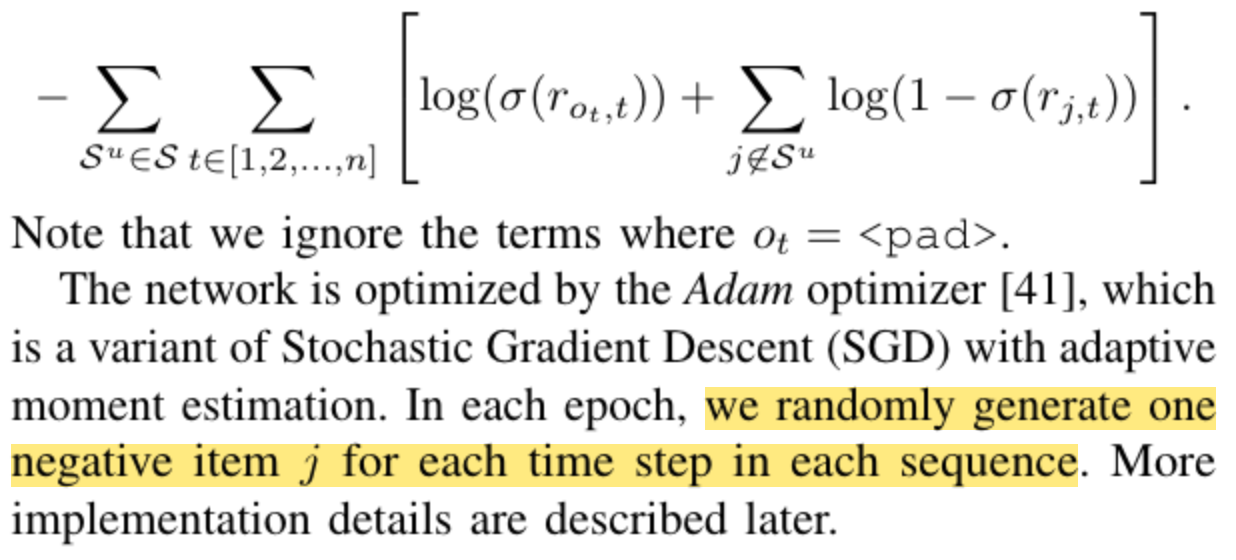

In [ ]:
class SASRecReal(SASRecModel):
    """
    SASRec model trained with Binary Cross-Entropy loss (negative sampling).

    For each position t in a user sequence, the model learns to distinguish between:
    - Positive: the ground-truth next item S^u_t (label = 1)
    - Negative: a randomly sampled item from the catalog (label = 0)

    The loss is computed as:
        L = BCE(scores, labels)
    where scores are computed as dot products between query embeddings (from backbone)
    and item embeddings (positive and negative).

    Parameters
    ----------
    backbone : SASRecBackbone
        The encoder backbone that produces contextualized user representations.

    Notes
    -----
    - Negative sampling is done uniformly at random from the entire item catalog.
    """

    def compute_loss(self, inputs: Dict, backbone_output: Dict[str, torch.Tensor]) -> torch.Tensor:
        # TODO: your code here
        pass


## 😇 Task 4. Реализация SASRec через использование in-batch негативов (1 балл)

Все же использовать полный софтмакс не всегда представляется возможным и рандомно семплировать объекты из всего каталога может быть нетривиально. Попробуем решить эти проблемы и использовать только то, что мы получаем на вход модели в батче.

$$\Large{\mathcal{L}_{\text{in batch}} = - \sum_{S^u \in S} \sum_{t \in [1, 2, \dots, n]}  \Bigg[  - \log \left( \frac{e^{r_{S^u_{t+1}, t}}}{e^{r_{S^u_{t+1}, t}} + \sum_{d \in Sample(B, k)}{e^{r_{d, t}}}} \right) \Bigg]},$$

где $k$ - количество негативов, для каждого семпла, $B$ - набор из всех идентификаторов в батче.


Реализуйте версию `SASRec`, которая использует in-batch negative sampling вместо случайного семплирования из каталога. Эта стратегия часто более эффективна, так как использует данные, уже находящиеся в памяти, и обычно даёт лучшие результаты благодаря более репрезентативным негативам.

Идея:
Вместо того чтобы случайно выбирать негативные айтемы из всего каталога, мы выбираем их из айтемов, уже присутствующих в текущем батче (то есть из целевых айтемов других примеров в батче). Это даёт нам "труднее" негативы — они более похожи на позитивные айтемы, чем совсем случайные объекты.

In [ ]:
class SASRecInBatch(SASRecModel):
    """
    SASRec model trained with using in-batch negative sampling.

    For each position t in a user sequence, the model learns to distinguish:
    - Positive: the ground-truth next item S^u_t
    - Negatives: `num_negatives` random items sampled from the given batch of target items

    This formulation is equivalent to multi-class classification where the model
    finds one positive among (1 + num_negatives) candidates.

    Parameters
    ----------
    backbone : SASRecBackbone
        The encoder backbone that produces contextualized user representations.
    num_negatives : int
        Number of negative samples per positive example.

    Notes
    -----
    - In-batch negatives are sampled uniformly from batch target items.
    """
    def __init__(
            self,
            backbone: SASRecBackbone,
            num_negatives: int
        ) -> None:
        super().__init__(backbone)
        self.num_negatives = num_negatives

    def compute_loss(self, inputs: Dict[str, torch.Tensor], backbone_output: Dict[str, torch.Tensor]) -> torch.Tensor:
        # TODO: your code here
        pass


## 🤩 Task 5. Реализация SASRec с добавлением log-q коррекции в in-batch подход (2 балла)

😢 Проблема предыдущего полхода: Смещение In-Batch Negative Sampling

При использовании in-batch negative sampling негативные примеры выбираются из целевых айтемов батча. Однако эти айтемы распределены неравномерно — популярные айтемы встречаются в батче чаще, чем редкие (long-tail distribution). Это вводит смещение: модель видит популярные айтемы чаще как негативы, что влияет на их финальные эмбеддинги.

Например, если айтем A популярен (часто встречается), он часто попадает в негативные примеры. Модель начинает "сильнее отталкивать" его представление, даже если это не всегда нужно. Это приводит к некорректным эмбеддингам популярных айтемов.

⭐ Решение: LogQ Correction

LogQ correction компенсирует это смещение, вычитая из скора негативного айтема логарифм его частоты в батче:

$$r_{i, t}^{*} = r_{i, t} - \log(Q(i)),$$

где $\large{Q(i) = \frac{\#i}{\#all}}$ - доля позитивных взаимодействий с айтемом $i$.

Это преобразование теоретически приводит к несмещённой оценке истинной вероятности взаимодействия, независимо от популярности айтема.

Для добавления log-q коррекции нам надо изменить только одну вещь: надо использовать скорректированную релевантность для негативов

Если вам интересен формальный вывод формул, советую посмотреть эти статьи:

1. [Sampling-Bias-Corrected Neural Modeling for Large Corpus Item Recommendations](https://research.google/pubs/sampling-bias-corrected-neural-modeling-for-large-corpus-item-recommendations/)
1. [Correcting the LogQ Correction: Revisiting Sampled Softmax for Large-Scale Retrieval](https://arxiv.org/abs/2507.09331)

Реализуйте расширенную версию in-batch negative sampling с использованием похода LogQ correction — техникой для компенсации смещения, вводимого in-batch negative sampling.

In [ ]:
def compute_item_statistics(dataset: YambdaDataset):
    item_counts = Counter()
    all_cnt = 0
    idx = 0
    while True:
        try:
            sample = dataset[idx]
            for item_id in sample['labels']['item_id']:
                item_counts[item_id] += 1
                all_cnt += 1
            idx += 1
        except:
            break

    return item_counts, all_cnt

In [ ]:
class SASRecInBatchWithLogQ(SASRecModel):
    """
    SASRec with in-batch negative sampling and LogQ bias correction.

    When negative samples are drawn from a batch, 
    they follow the empirical distribution of the data (popular items
    appear more frequently), which can bias the learned embeddings.

    Parameters
    ----------
    backbone : SASRecBackbone
        The encoder backbone that produces contextualized user representations.
    num_negatives : int
        Number of negative samples per positive example (sampled from batch).
    item_freqs : torch.Tensor
        1D tensor of shape (num_items,) containing frequency/probability of each
        item in the training data. Used for LogQ correction.
        Example: item_freqs[i] = (count of item i) / (total items in dataset)
    """
    def __init__(
            self,
            backbone: SASRecBackbone,
            num_negatives: int,
            item_freqs: torch.Tensor
        ) -> None:
        super().__init__(backbone=backbone)
        self.num_negatives = num_negatives
        self.register_buffer('item_freqs', item_freqs)

    def apply_correction(self, scores: torch.Tensor, freqs: torch.Tensor) -> torch.Tensor:
        # TODO: your code here
        pass

    def compute_loss(self, inputs: Dict[str, torch.Tensor], backbone_output: Dict[str, torch.Tensor]) -> torch.Tensor:
        # TODO: your code here
        pass

## 🎯 Task 6. Реализовать метрики для измерения качества полученных моделей (1 балл)

Для того, чтобы понимать насколько хорошо работает наша модель, нам нужно определиться с метриками, который мы хотим считать на валидации и тесте. В рамках данного семинара предлагается использовать следующие метрики:

$$\text{HitRate@k} = \frac{1}{|S|} \sum_{S^u \in S}{ \mathbb{I} [ \text{positive} \in \text{recommended}[:\text{k}]] },$$

$$\text{DCG@k} = \frac{1}{|S|}\sum_{S^u \in S}{}{\sum_{i = 1}^{k} \frac{\mathbb{I} [ \text{recommended}^u_i = \text{positive} ] }{\log_2(i + 1)}},$$

$$\text{Coverage@k} = \frac{ \bigcup_{S^u \in S}{ \bigcup_{i=1}^{k}{ \text{recommended}^u_i}} }{|\mathcal{I}|},$$

где $\text{positive}$ - следующее позитивное взаимодействие, а $\text{recommended}$ - упорядоченная выдача, список айдишников упорядоченный по убыванию. $\mathcal{I}$ - весь каталог айтемов.

Важно заметить, что так как у нас только один позитив, то для нашего случая $\text{HitRate@k} = \text{Recall@k}$ и $\text{DCG@k} = \text{nDCG@k}$


In [ ]:
def compute_hitrate(all_scores: torch.Tensor, positive_scores: torch.Tensor, k: int) -> List[float]:
    """
    Computes Hit Rate@k for each sample in the batch.

    Hit Rate measures whether the ground truth positive item appears in the top-k
    ranked items. For each user, it's a binary metric: 1 if the positive item is
    in top-k, 0 otherwise.

    Hit Rate@k = 1 if rank(positive_item) < k, else 0

    Parameters
    ----------
    all_scores : torch.Tensor
        Relevance scores for all items in the catalog, shape (batch_size, num_items).
        Higher scores indicate higher relevance.
    positive_scores : torch.Tensor
        Relevance scores for the ground truth positive items (targets), 
        shape (batch_size,).
    k : int
        Cutoff for top-k evaluation. Typical values: 1, 5, 10, 20, 50, 100.

    Returns
    -------
    List[float]
        Hit Rate values for each sample in the batch, shape (batch_size,).
        Each value is either 0.0 (miss) or 1.0 (hit).
    """
    # TODO: your code here
    pass


def compute_dcg(all_scores: torch.Tensor, positive_scores: torch.Tensor, k: int) -> List[float]:
    """
    Computes DCG@k for each sample in the batch.

    DCG (Discounted Cumulative Gain) measures ranking quality with position discount.
    For a single positive item at position p (0-indexed):
        DCG@k = 1 / log2(p + 2) if p < k else 0

    Parameters
    ----------
    all_scores : torch.Tensor
        Scores for all items, shape (batch_size, num_items).
    positive_scores : torch.Tensor
        Scores for the ground truth positive items, shape (batch_size,).
    k : int
        Cutoff for evaluation (top-k).

    Returns
    -------
    List[float]
        DCG@k values for each sample in the batch.
    """
    # TODO: your code here
    pass


def compute_metrics(all_scores: torch.Tensor, positive_scores: torch.Tensor) -> Dict[str, float]:
    return {
        'dcg@10': compute_dcg(all_scores, positive_scores, k=10),
        'dcg@100': compute_dcg(all_scores, positive_scores, k=100),
        'dcg@1000': compute_dcg(all_scores, positive_scores, k=1000),

        'hitrate@10': compute_hitrate(all_scores, positive_scores, k=10),
        'hitrate@100': compute_hitrate(all_scores, positive_scores, k=100),
        'hitrate@1000': compute_hitrate(all_scores, positive_scores, k=1000),
    }

In [ ]:
def test_compute_hitrate():
    assert compute_hitrate(torch.tensor([[0.9, 0.5]]), torch.tensor([0.9]), k=1) == [1.0]
    assert compute_hitrate(torch.tensor([[0.9, 0.5]]), torch.tensor([0.5]), k=1) == [0.0]
    assert compute_hitrate(torch.tensor([[0.9, 0.5]]), torch.tensor([0.5]), k=2) == [1.0]
    
    all_scores = torch.tensor([[0.9, 0.5, 0.3], [0.9, 0.8, 0.7]])
    positive = torch.tensor([0.9, 0.8])
    assert compute_hitrate(all_scores, positive, k=2) == [1.0, 1.0]
    
    print('✅ test_compute_hitrate: OK')


def test_compute_dcg():
    import math
    
    assert abs(compute_dcg(torch.tensor([[0.9, 0.5]]), torch.tensor([0.9]), k=2)[0] - 1.0) < 1e-5
    
    expected = 1.0 / math.log2(3)
    assert abs(compute_dcg(torch.tensor([[0.9, 0.5]]), torch.tensor([0.5]), k=2)[0] - expected) < 1e-5
    
    assert abs(compute_dcg(torch.tensor([[0.9, 0.8, 0.5]]), torch.tensor([0.5]), k=3)[0] - 0.5) < 1e-5
    
    assert compute_dcg(torch.tensor([[0.9, 0.8, 0.7, 0.5]]), torch.tensor([0.5]), k=2)[0] == 0.0
    
    print('✅ test_compute_dcg: OK')


test_compute_hitrate()
test_compute_dcg()


# 🔥 Обучение и валидация моделей

## 🎰 Валидация / эвал модели

In [ ]:
def evaluation(
        dataloader: DataLoader, 
        model: SASRecModel,
        device: str = 'cpu',
        num_batches: Optional[int] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    eval_metrics = defaultdict(list)

    model.eval()

    for idx, batch in enumerate(dataloader):
        for key in batch:
            if isinstance(batch[key], dict):
                for sub_key in batch[key]:
                    batch[key][sub_key] = batch[key][sub_key].to(device)
            else:
                assert isinstance(batch[key], torch.Tensor)
                batch[key] = batch[key].to(device)

        with torch.inference_mode():
            model_output = model(batch)
            batch_metrics = compute_metrics(model_output['all_scores'], model_output['positive_scores'])
        for key, values in batch_metrics.items():
            eval_metrics[key].extend(values)
        
        if num_batches is not None and idx + 1 >= num_batches:
            break
            
    for key, values in eval_metrics.items():
        eval_metrics[key] = np.mean(values)
    
    return eval_metrics


## 🔁 Цикл обучения

In [ ]:
def train(
        train_dataloader: DataLoader, 
        valid_dataloader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int | None = None,
        device: str = 'cpu',
        num_valid_batches: Optional[int] = None
    ) -> torch.nn.Module:
    step_num = 0
    epoch_num = 0

    best_checkpoint = None
    best_metric_name = 'dcg@1000'
    best_metric_value = float('-inf')

    while num_epochs is None or epoch_num < num_epochs:
        print(f'Start epoch {epoch_num + 1}')
        running_loss = []

        for batch in train_dataloader:
            model.train()

            for key in batch:
                if isinstance(batch[key], dict):
                    for sub_key in batch[key]:
                        batch[key][sub_key] = batch[key][sub_key].to(device)
                else:
                    assert isinstance(batch[key], torch.Tensor)
                    batch[key] = batch[key].to(device)

            loss = model(batch)['loss']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            step_num += 1

            running_loss.append(loss.item())

        # Запускаем валидацию
        valid_metrics = evaluation(valid_dataloader, model, device, num_valid_batches)

        if best_metric_value is None or best_metric_value < valid_metrics[best_metric_name]:
            best_metric_value = valid_metrics[best_metric_name]
            best_checkpoint = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        msgs = []
        for metric_name, metrinc_value in valid_metrics.items():
            msgs.append(f'{metric_name}: {round(metrinc_value, 5)}')
        msg = ', '.join(msgs)
        print(msg)

        # Прогоняем валидацию и эвал
        print(f'Средний лосс на эпохе #{epoch_num + 1}: {round(np.mean(running_loss), 5)}')
        
        epoch_num += 1

    print('Обучение завершено!')

    return best_checkpoint

## 🏁 Все готово для обучения модели

1️⃣ Готовим данные

In [ ]:
train_dataset = YambdaDataset(dataframe=train_data, max_seq_len=MAX_SEQ_LEN)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    drop_last=True, 
    collate_fn=collate_fn
)

valid_dataset = YambdaDataset(dataframe=valid_data, max_seq_len=MAX_SEQ_LEN)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=True, 
    drop_last=False, 
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=collate_fn
)

eval_dataset = YambdaDataset(dataframe=eval_data, max_seq_len=MAX_SEQ_LEN)
eval_dataloader = DataLoader(
    dataset=eval_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=True, 
    drop_last=False, 
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=collate_fn
)

2️⃣ Обучаем `SASRecReal`

In [ ]:
model_real = SASRecReal(
    backbone=SASRecBackbone(
        num_items=len(item_mapping),
        embedding_dim=EMBEDDING_DIM,
        num_heads=NUM_HEADS,
        max_seq_len=MAX_SEQ_LEN,
        dropout_rate=DROPOUT_RATE,
        num_transformer_layers=NUM_TRANSFORMER_LAYERS
    )
).to(DEVICE)
optimizer_real = torch.optim.Adam(params=model_real.parameters(), lr=LEARNING_RATE)

best_checkpoint_real = train(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model_real,
    optimizer=optimizer_real,
    num_epochs=NUM_EPOCHS,
    device=DEVICE
)

3️⃣ Обучаем `SASRecInBatch`

In [ ]:
model_in_batch = SASRecInBatch(
    backbone=SASRecBackbone(
        num_items=len(item_mapping),
        embedding_dim=EMBEDDING_DIM,
        num_heads=NUM_HEADS,
        max_seq_len=MAX_SEQ_LEN,
        dropout_rate=DROPOUT_RATE,
        num_transformer_layers=NUM_TRANSFORMER_LAYERS
    ),
    num_negatives=TRAIN_BATCH_SIZE
).to(DEVICE)
optimizer_in_batch = torch.optim.Adam(params=model_in_batch.parameters(), lr=LEARNING_RATE)

best_checkpoint_in_batch = train(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model_in_batch,
    optimizer=optimizer_in_batch,
    num_epochs=NUM_EPOCHS,
    device=DEVICE
)


4️⃣ Обучаем `SASRecInBatchWithLogQ`

In [ ]:
item_freqs = torch.zeros(len(item_mapping), dtype=torch.float32)

item_statistics, num_labels = compute_item_statistics(train_dataloader)
for key, val in item_statistics.items():
    item_statistics[key] = val / num_labels
    assert 0 <= item_statistics[key] < 1.0

model_inbatch_logq = SASRecInBatchWithLogQ(
    backbone=SASRecBackbone(
        num_items=len(item_mapping),
        embedding_dim=EMBEDDING_DIM,
        num_heads=NUM_HEADS,
        max_seq_len=MAX_SEQ_LEN,
        dropout_rate=DROPOUT_RATE,
        num_transformer_layers=NUM_TRANSFORMER_LAYERS
    ),
    num_negatives=TRAIN_BATCH_SIZE,
    item_freqs=item_freqs
).to(DEVICE)
optimizer_inbatch_logq = torch.optim.Adam(params=model_inbatch_logq.parameters(), lr=LEARNING_RATE)

best_checkpoint_inbatch_logq = train(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model_inbatch_logq,
    optimizer=optimizer_inbatch_logq,
    num_epochs=NUM_EPOCHS,
    device=DEVICE
)

# Task 7. Побить пороги на тестовой выборке (1 балл)

1️⃣ Измеряем качество на тесте для `SASRecReal`

In [ ]:
def test_model_real_quality():    
    model_real.load_state_dict(best_checkpoint_real)
    eval_metrics = evaluation(eval_dataloader, model_real, device=DEVICE)
    print(eval_metrics)
    
    thresholds = {
        'dcg@10': 0.002,
        'dcg@100': 0.007,
        'dcg@1000': 0.02,
        'hitrate@10': 0.004,
        'hitrate@100': 0.03,
        'hitrate@1000': 0.15
    }
    
    for metric_name, threshold in thresholds.items():
        actual = eval_metrics[metric_name]
        assert actual >= threshold, \
            f'❌ {metric_name}: {actual} < {threshold}'
        print(f'✅ {metric_name}: {actual} >= {threshold}')
    
    print('\n✅ test_model_real_quality: OK')

test_model_real_quality()


2️⃣ Измеряем качество на тесте для `SASRecInBatch`

In [ ]:
def test_model_in_batch_quality():    
    model_in_batch.load_state_dict(best_checkpoint_in_batch)
    eval_metrics = evaluation(eval_dataloader, model_in_batch, device=DEVICE)
    print(eval_metrics)
    
    thresholds = {
        'dcg@10': 0.005,
        'dcg@100': 0.016,
        'dcg@1000': 0.04,
        'hitrate@10': 0.01,
        'hitrate@100': 0.06,
        'hitrate@1000': 0.25
    }
    
    for metric_name, threshold in thresholds.items():
        actual = eval_metrics[metric_name]
        assert actual >= threshold, \
            f'❌ {metric_name}: {actual} < {threshold}'
        print(f'✅ {metric_name}: {actual} >= {threshold}')
    
    print('\n✅ test_model_in_batch_quality: OK')

test_model_in_batch_quality()

3️⃣ Измеряем качество на тесте для `SASRecInBatchWithLogq`

In [ ]:
def test_model_in_batch_logq_quality():    
    model_inbatch_logq.load_state_dict(best_checkpoint_inbatch_logq)
    eval_metrics = evaluation(eval_dataloader, model_inbatch_logq, device=DEVICE)
    print(eval_metrics)
    
    thresholds = {
        'dcg@10': 0.0075,     
        'dcg@100': 0.018,
        'dcg@1000': 0.043,
        'hitrate@10': 0.015,
        'hitrate@100': 0.075,
        'hitrate@1000': 0.29
    }
    
    for metric_name, threshold in thresholds.items():
        actual = eval_metrics[metric_name]
        assert actual >= threshold, \
            f'❌ {metric_name}: {actual} < {threshold}'
        print(f'✅ {metric_name}: {actual} >= {threshold}')
    
    print('\n✅ test_model_in_batch_logq_quality: OK')

test_model_in_batch_logq_quality()

# 🧠 Немного литературы

Статьи из индустрии:
1. [PinnerFormer: Sequence Modeling for User Representation at Pinterest](https://arxiv.org/pdf/2205.04507)
1. [Actions Speak Louder than Words: Trillion-Parameter Sequential Transducers for Generative Recommendations](https://arxiv.org/pdf/2402.17152v1)
1. [Better Generalization with Semantic IDs: A Case Study in Ranking for Recommendations](https://arxiv.org/pdf/2306.08121)
1. [Sampling-Bias-Corrected Neural Modeling for Large Corpus Item Recommendations](https://research.google/pubs/sampling-bias-corrected-neural-modeling-for-large-corpus-item-recommendations/)
1. [Correcting the LogQ Correction: Revisiting Sampled Softmax for Large-Scale Retrieval](https://arxiv.org/abs/2507.09331)


Про то, как надо и не надо валидироваться:
1. [A Critical Study on Data Leakage in Recommender System Offline Evaluation](https://dl.acm.org/doi/full/10.1145/3569930)
1. [Exploring Data Splitting Strategies for the Evaluation of Recommendation Models](https://arxiv.org/pdf/2007.13237)


Статьи из академии:
1. [SASRec: Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)
1. [BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer](https://arxiv.org/abs/1904.06690)
1. [A Systematic Review and Replicability Study of BERT4Rec for Sequential Recommendation](https://dl.acm.org/doi/10.1145/3523227.3548487)
1. [CL4SRec Contrastive Learning for Sequential Recommendation](https://arxiv.org/abs/2010.14395)
1. [DuoRec: Contrastive Learning for Representation Degeneration Problem in Sequential Recommendation](https://arxiv.org/abs/2110.05730)


Про инфру:
1. [Semantic Product Search](https://dl.acm.org/doi/10.1145/3292500.3330759)
1. [Monolith: Real Time Recommendation System With Collisionless Embedding Table](https://arxiv.org/pdf/2209.07663)
